<a href="https://colab.research.google.com/github/BC-Chang/LBM_Workshop/blob/master/D2Q9_LBM_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A D2Q9 Lattice Boltzmann Simulation

In this first hands-on activity, we will demonstrate the general algorithm used to perform lattice Boltzmann simulations. This example is performed on a 2-dimensional lattice with 9 discrete velocities (D2Q9).

An overview of the algorithm implemented here is as follows:

1. Apply outflow boundary condition on the right boundary
2. Compute Macroscopic Quantities (density and velocities)
3. Apply Inflow Profile by Zou/He Dirichlet Boundary Condition
   on the left boundary
4. Compute the discrete equilibria velocities
5. Perform a Collision step according to BGK (Bhatnagar–Gross–Krook)
6. Apply Bounce-Back Boundary Conditions on the cylinder obstacle
7. Stream alongside the lattice velocities
8. Advance in time (repeat the loop)

Before we get started, let's import some packages


In [5]:
#@title Import Packages
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import tifffile

import sys
import os
try:
  sys.path.append("./LBM_Workshop/")
except:
  !git clone https://github.com/BC-Chang/LBM_Workshop.git

os.chdir("./LBM_Workshop")
from plotting_utils import plot_profile, plot_quiver, plot_streamlines

# Import a timer
from time import perf_counter_ns

# Import ipywidgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import display, clear_output




### Step-by-step introduction to the lattice Boltzmann method

For this exercise, we will use a 2-dimensional lattice with 9 discrete velocities (D2Q9). This means, that in every grid space, there are 9 possible connections — North, South, East, West, 4 diagonal connections and 1 connection from the node itself, representing zero velocity.

Each lattice direction also has a weight, $w_i$ associated with it. For D2Q9 LBM, these will be:

<img src='https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs11831-019-09347-7/MediaObjects/11831_2019_9347_Fig2_HTML.png?as=webp' height="300">


In the following cell, we will initialize these velocity directions and their weights.


In [19]:
# Define lattice velocity vectors. Transpose to make it a column vector
ex = np.array([0, 1, 0, -1, 0, 1, -1, -1, 1], dtype=np.double)
ey = np.array([0, 0, 1, 0, -1, 1, 1, -1, -1], dtype=np.double)


# Define weights
w_i = np.array([4./9.,
                1./9.,
                1./9.,
                1./9.,
                1./9.,
                1./36.,
                1./36.,
                1./36.,
                1./36.], dtype=np.double)

Microscopic particles that make up a fluid can be described with the distribution function $f$, which describes the phase-space density of fluids.

Particles will do two things: **stream** and **collide**. This behavior is described by the BGK approximation:
$(\partial_t + \textbf{v}\cdot\nabla)f = - \frac{f - f^{eq}}{\tau}$

Here, the left-hand side represents streaming and the right-hand side approximates collisions. $\tau$ is the timescale over which collisions occur and the distribution function $f$ tends toward some equilibrium state, $f^{eq}$.

###  Read in the geometry
Before we get into the flow simulation, let's first read in our geometry. For this exercise, we assume a 2D binary image with:
- 0 indicating fluid space
- 1 indicating solid space

For this workshop, we select an image from the data folder. You can also load in your own image or create one yourself if you'd like.


In [17]:
#@title Read in data
geom_options = os.listdir("./data/")

# TODO create catalog of images, read in from drop down, and plot. 
data_dropdown = widgets.Dropdown(
    concise=False,
    options=geom_options,
    value='beads.tif',
    description='Select a file to read in'
)

# select_button = widgets.Button(description='I want this one!')
# output = widgets.Output()
def read_in_and_plot(dropdown):
  display(dropdown)
  data = tifffile.imread(os.path.join("./data/", dropdown))
  clear_output(wait=True)
  display(dropdown)
  plt.imshow(data, cmap='binary_r')
  plt.colorbar()
  plt.show()

  return data

widget = widgets.interactive(read_in_and_plot, dropdown=geom_options)
display(widget)


interactive(children=(Dropdown(description='dropdown', options=('bevo.tif', 'beads.tif'), value='bevo.tif'), O…

In [9]:
def run_lbm(data):
    from time import perf_counter_ns
    # Initialization
    tau = 1.0  # Relaxation time
    g = 0.00001  # Gravity or other force
    density = 1.
    tf = 10001  # Maximum number of iteration steps
    precision = 1.E-5  # Convergence criterion
    vold = 1000
    eps = 1E-6

    check_convergence = 30  # Check convergence every [check_convergence] time steps


    # Indices of fluid nodes
    fluid_id = np.argwhere(data == 0)
    fx = fluid_id[:, 0]
    fy = fluid_id[:, 1]

    # Indices of solid nodes
    solid_id = np.argwhere(data == 1)
    sx = solid_id[:, 0]
    sy = solid_id[:, 1]

    # Solid nodes are labeled 1, fluid nodes are labeled 0
    is_solid_node = data

    nx, ny = data.shape

    # Initialize distribution functions
    f = w_i * density

    # Broadcast to 3D array with each slice corresponding to
    f = np.tile(f[:, np.newaxis, np.newaxis], (nx, ny)).astype(np.single)

    # Allocate memory to equilibrium functions
    feq = np.empty_like(f, dtype=np.double)

    # Each point has x-component ex, and y-component ey
    u_x = np.empty((nx, ny), dtype=np.double)
    u_y = np.empty((nx, ny), dtype=np.double)

    # Node density
    rho = np.zeros((nx, ny), dtype=np.double)

    # For equilibrium distribution function (feq) calculation
    f1 = 3.
    f2 = 9./2.
    f3 = 3./2.

    # # Begin time loop
    tic = perf_counter_ns()
    for ts in range(tf):
        # print(f"{ts = }")  # Print timestep

        # Compute macroscopic density, rho and velocity.
        u_x = np.zeros((nx, ny), dtype=np.double)
        u_y = np.zeros((nx, ny), dtype=np.double)
        rho = np.zeros((nx, ny), dtype=np.double)

        rho[fx, fy] += np.sum(f[:, fx, fy], axis=0)
        u_x[fx, fy] += np.sum(ex[:, None] * f[:, fx, fy], axis=0)
        u_y[fx, fy] += np.sum(ey[:, None] * f[:, fx, fy], axis=0)

        u_x[fx, fy] = u_x[fx, fy] / rho[fx, fy]
        u_y[fx, fy] = u_y[fx, fy] / rho[fx, fy]



        # Add forcing to velocity
        ueqxij = u_x[fx, fy] + tau * g
        ueqyij = u_y[fx, fy]
        uxsq = ueqxij ** 2
        uysq = ueqyij ** 2
        uxuy5 = ueqxij + ueqyij
        uxuy6 = -ueqxij + ueqyij
        uxuy7 = -ueqxij + (-ueqyij)
        uxuy8 = ueqxij + (-ueqyij)
        usq = uxsq + uysq

        # Compute equilibrium distribution function, feq
        rt0 = 4./9. * rho[fx, fy]
        rt1 = 1./9. * rho[fx, fy]
        rt2 = 1./36. * rho[fx, fy]

        feq[0, fx, fy] = rt0*(1. - f3 * usq)
        feq[1, fx, fy] = rt1*(1. + f1 * ueqxij + f2 * uxsq - f3 * usq)
        feq[2, fx, fy] = rt1*(1. + f1 * ueqyij + f2 * uysq - f3 * usq)
        feq[3, fx, fy] = rt1*(1. - f1 * ueqxij + f2 * uxsq - f3 * usq)
        feq[4, fx, fy] = rt1*(1. - f1 * ueqyij + f2 * uysq - f3 * usq)
        feq[5, fx, fy] = rt2*(1. + f1 * uxuy5  + f2 * uxuy5 * uxuy5 - f3 * usq)
        feq[6, fx, fy] = rt2*(1. + f1 * uxuy6  + f2 * uxuy6 * uxuy6 - f3 * usq)
        feq[7, fx, fy] = rt2*(1. + f1 * uxuy7  + f2 * uxuy7 * uxuy7 - f3 * usq)
        feq[8, fx, fy] = rt2*(1. + f1 * uxuy8  + f2 * uxuy8 * uxuy8 - f3 * usq)

        # Collision Step
        # Standard Bounceback for Solid Nodes
        # Left-Right
        f[1, sx, sy], f[3, sx, sy] = f[3, sx, sy], f[1, sx, sy]

        # Up-Down
        f[2, sx, sy], f[4, sx, sy] = f[4, sx, sy], f[2, sx, sy]

        # Top Right - Bottom Left
        f[5, sx, sy], f[7, sx, sy] = f[7, sx, sy], f[5, sx, sy]

        # Top Left - Bottom Right
        f[6, sx, sy], f[8, sx, sy]  = f[8, sx, sy], f[6, sx, sy]

        # Regular collision in fluid nodes
        f[:, fx, fy] -= (f[:, fx, fy] - feq[:, fx, fy]) / tau


        # Streaming Step
        f[1] = np.roll(f[1], 1, axis=1)
        f[2] = np.roll(f[2], 1, axis=0)
        f[3] = np.roll(f[3], -1, axis=1)
        f[4] = np.roll(f[4], -1, axis=0)

        f[5] = np.roll(f[5], (1, 1), axis=(0,1))
        f[6] = np.roll(f[6], (-1, 1), axis=(1,0))
        f[7] = np.roll(f[7], (-1, -1), axis=(0,1))
        f[8] = np.roll(f[8], (1, -1), axis=(1,0))

        u = np.sqrt(u_x**2 + u_y**2)
        # Plot the time step and check convergence every check_convergence time step
        if ts % check_convergence == 0:

            vnew = np.mean(u)
            error = np.abs(vold - vnew) / (vold+eps)
            vold = vnew

            if error < precision:
                print(f'Simulation has converged in {ts} time steps')
                break

        if ts == tf:
            print('Reached maximum iterations')

    toc = perf_counter_ns()
    print(f"Elapsed Time: {(toc - tic)*1E-9}s")

    return u_x, u_y, u

In [15]:
 data = widget.result
 u_x, u_y, u = run_lbm(data)

Elapsed Time: 99.433445054s


<Figure size 1800x1200 with 0 Axes>

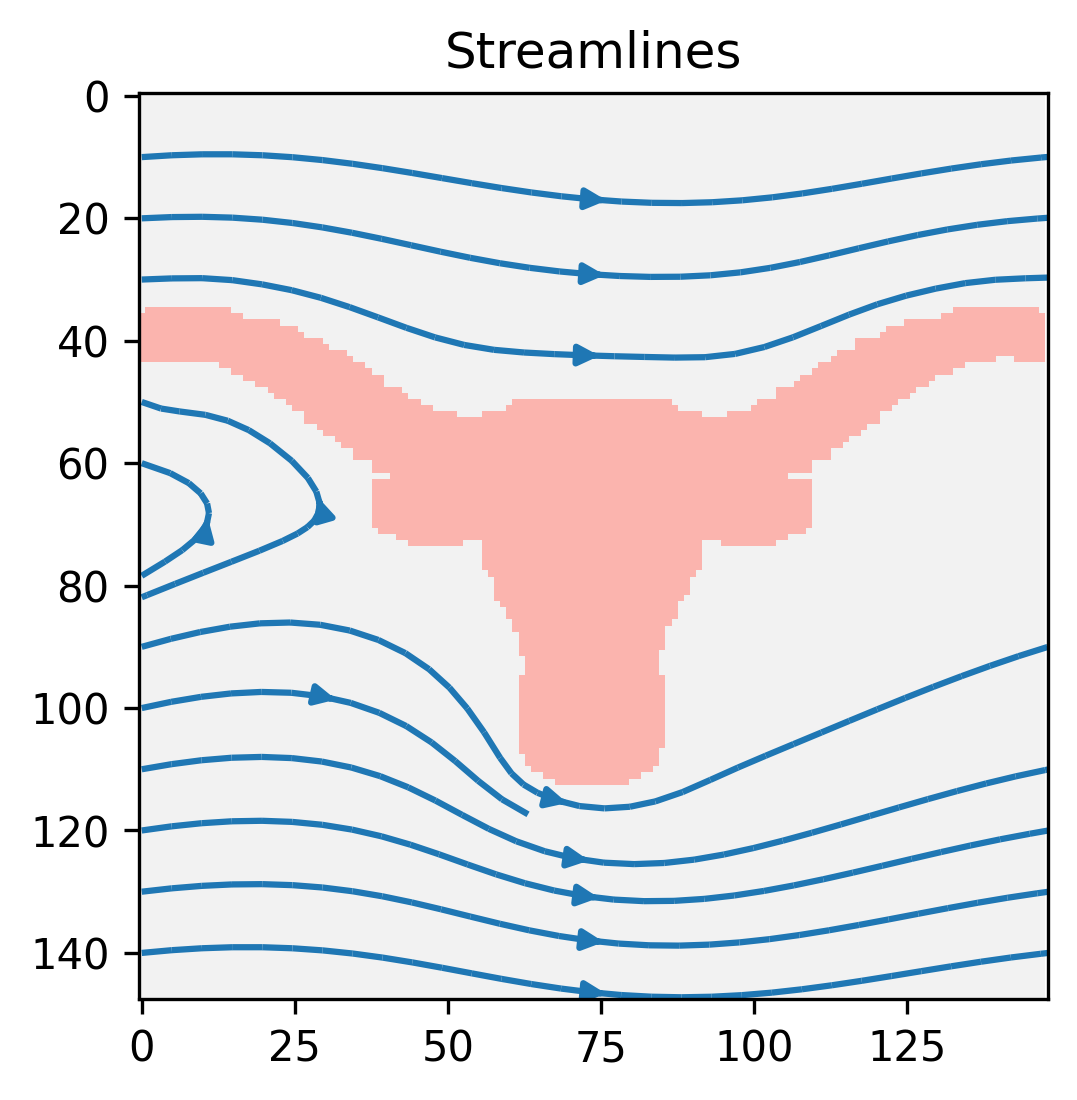

In [18]:
profile_fig = plot_streamlines(u_x, u_y, cmap='jet')